In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.linalg import solve_triangular
from data_utils import load_dataset
from scipy.linalg import cho_factor, cho_solve

# Q4. Construct a RBF Model Minimizing Least-Squares Loss

Since I want (i, j) value of the K matrix to contain the result of gaussian function k(||x(i) - z(j)||), I can vectorize this by using Numpy broadcasting.
If I subtract matrix of dimension (M, D) by one with (N, D), I get a dimension error. However, I can subtract a (M, 1, D) matrix by a (1, N, D) matrix to get 
a (M, N, D) matrix where entry (i, j) is a Dx1 vector obtained from x(i) - z(j).


In [2]:
# applies the Gaussian kernel function k(r) 
def gaussian_kernel(differ, theta):
    return np.exp(-np.square(LA.norm(differ, 2, axis=2)) / theta)

# used to compute the Gram Matrix K using the x_train values 
def gaussian_GramMatrix(x, z, theta):
    # x is [M x D], z is [N x D]
    # return matrix K which is [N x M]
    x = np.expand_dims(x, axis=1)
    z = np.expand_dims(z, axis=0)
    K = gaussian_kernel(x-z, theta)
    return K 

# compute the predictions based on the K matrix, returns predictions 
def compute_predictions(K, lambda_val, theta, x_train, x_valid, y_train):
    R = cho_factor(K + lambda_val*np.identity(x_train.shape[0]))
    alpha = cho_solve(R, y_train)
    new_K = gaussian_GramMatrix(x_valid, x_train, theta)
    predictions = np.dot(new_K, alpha)
    return predictions

# define evaludation functions 
def evaluate_RMSE(predictions, y_test):
    rmse = np.sqrt(np.mean(np.square(predictions - y_test)))
    return rmse 

def evaluate_accuracy(predictions, y_test):
    accuracy = np.count_nonzero(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
    return accuracy

# function that finds the best hyperparameters (smallest RMSE loss)
def find_best_parameters_rmse(RMSE_losses, lambda_array, theta_array):
    smallest_loss = float('inf')
    best_parameters = [0,0] 
    for lambda_index, lambda_val in enumerate(lambda_array):
        for theta_index, theta_val in enumerate(theta_array):
            if RMSE_losses[lambda_index, theta_index] <= smallest_loss:
                smallest_loss = RMSE_losses[lambda_index, theta_index]
                best_parameters = [lambda_val, theta_val]
    return best_parameters, smallest_loss

# function that produces the best hyperparameters based on largest accuracy 
def find_most_accurate_parameters(accuracies, lambda_array, theta_array):
    biggest_accuracy = float(0)
    best_parameters = [0,0] #k, metric
    for lambda_index, lambda_val in enumerate(lambda_array):
        for theta_index, theta_val in enumerate(theta_array):
            if accuracies[lambda_index, theta_index] >= biggest_accuracy:
                biggest_accuracy = accuracies[lambda_index, theta_index]
                best_parameters = [lambda_val, theta_val]
    return best_parameters, biggest_accuracy

# define the model building and testing function 
def get_RBF_model_and_test(name, lambda_array, theta_array):
    """used to estimate for the best hyperparameters and also run on the test set 

    @param name: the name of the dataset
    @param theta_array: the theta values to test 
    @param lambda_array: the regularization parameters to test 
    """
    print("Following information is for the dataset: ", name)
    if name == 'rosenbrock':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name, d=2, n_train=1000)
    else:
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name)
    # initialize the validation loss array
    loss_array = np.zeros((lambda_array.size, theta_array.size))
    # for-loop of the theta values nested in a for-loop of the lambda values
    for lambda_index, lambda_val in enumerate(lambda_array):
        for theta_index, theta_val in enumerate(theta_array):
            K = gaussian_GramMatrix(x=x_train, z=x_train, theta=theta_val)
            # compute the validation predictions using the Cholesky factorization method
            validation_predictions = compute_predictions(K=K, lambda_val=lambda_val, theta=theta_val, x_train=x_train, x_valid=x_valid, y_train=y_train)
            # compute loss, accuracy for iris and RMSE for mauna_loa and rosenbrock 
            if name == 'iris':
                loss_array[lambda_index, theta_index] = evaluate_accuracy(validation_predictions, y_valid)
            else:
                loss_array[lambda_index, theta_index] = evaluate_RMSE(validation_predictions, y_valid)
            #print("For lambda = %d and theta = l_%d, the validation accuracy is %.8f" % (lambda_val, theta_val, loss_array[lambda_index, theta_index]))
        
    # now that validation is completed for all hyperparameter configurations, find the configuration with the smallest RMSE loss OR highest accuracy depending on which dataset this is 
    if name == 'iris':
        best_parameters, largest_accuracy = find_most_accurate_parameters(loss_array, lambda_array, theta_array)
        print("The best parameter configuration for dataset {" + name + "} is lambda = %.4f and theta = %.4f, with an accuracy of %.8f" % (best_parameters[0], best_parameters[1], largest_accuracy))

    else:
        best_parameters, smallest_loss = find_best_parameters_rmse(loss_array, lambda_array, theta_array)
        print("The best parameter configuration for dataset {" + name + "} is lambda = %.4f and theta = %.4f, with a RMSE loss of %.8f" % (best_parameters[0], best_parameters[1], smallest_loss))
    
    # TEST USING BEST HYPERPARAMETERS 
    # use all train + validation data for the final testing 
    combined_x_train = np.vstack([x_valid, x_train])
    combined_y_train = np.vstack([y_valid, y_train])
    (best_lambda, best_theta) = best_parameters
    # apply the best parameters to the test set 
    K = gaussian_GramMatrix(combined_x_train, combined_x_train, best_theta)
    test_predictions = compute_predictions(K, best_lambda, best_theta, combined_x_train, x_test, combined_y_train)    
    if name == 'iris':
        test_accuracy = evaluate_accuracy(test_predictions, y_test)
        print("The test accuracy with best hyperparameters is: ", test_accuracy)
    else:
        test_loss = evaluate_RMSE(test_predictions, y_test)
        print("The test RMSE loss with best hyperparameters is: ", test_loss)

    print('-'*100)

In [3]:
lambda_array = np.array([0.001, 0.01, 0.1, 1])
theta_array = np.array([0.05, 0.1, 0.5, 1, 2])
get_RBF_model_and_test('mauna_loa', lambda_array, theta_array)
get_RBF_model_and_test('rosenbrock', lambda_array, theta_array)
get_RBF_model_and_test('iris', lambda_array, theta_array)

Following information is for the dataset:  mauna_loa
The best parameter configuration for dataset {mauna_loa} is lambda = 0.0010 and theta = 1.0000, with a RMSE loss of 0.12447867
The test RMSE loss with best hyperparameters is:  0.14977338771886906
----------------------------------------------------------------------------------------------------
Following information is for the dataset:  rosenbrock
The best parameter configuration for dataset {rosenbrock} is lambda = 0.0010 and theta = 2.0000, with a RMSE loss of 0.19323959
The test RMSE loss with best hyperparameters is:  0.1481244275513496
----------------------------------------------------------------------------------------------------
Following information is for the dataset:  iris
The best parameter configuration for dataset {iris} is lambda = 1.0000 and theta = 2.0000, with an accuracy of 0.87096774
The test accuracy with best hyperparameters is:  1.0
--------------------------------------------------------------------------

# Q5. Greedy Algorithm Using a Dictionary of Basis Functions


The mauna_loa dataset is 1 dimensional. The x-y mapping appear to be polynomial from a macroscopic perspective, while oscillating at an approximately constant frequency with a period of about 0.0568 based on a manual examination of the data's plot. 

Text(0.5,1,'Mauna_loa data')

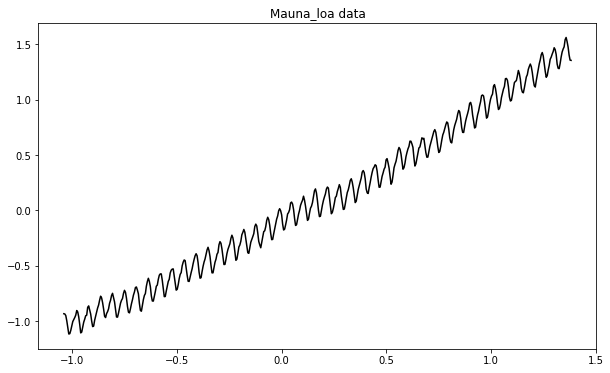

In [4]:
# visualize mauna_loa data
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
plt.figure(figsize=(10,6))
plt.plot(x_train, y_train, 'k')
plt.title('Mauna_loa data')

In [5]:
def create_basis(x):
    # creates evaluated basis functions, PHI is N by M, row i is x_train_val[i] evaluated for all M basis functions   
    # first column is just the bias term = 1   
    PHI = np.ones((x.shape[0], 1)) 
    # add trigonometric functions with varying coefficients, frequencies, and also multiplied with x 
    data_period = 0.0568
    for coeff in [1, np.sqrt(2), 2]:
        for freq_coeff in np.linspace(0.5, 2, num=40):
            omega = 2*np.pi*freq_coeff/data_period
            PHI = np.hstack([PHI, coeff*np.sin(omega*x)])
            PHI = np.hstack([PHI, coeff*np.cos(omega*x)])
            PHI = np.hstack([PHI, coeff*x*np.sin(omega*x)])
            PHI = np.hstack([PHI, coeff*x*np.cos(omega*x)])
    # add polynomial terms with varying coefficients 
    for coeff in [1, np.sqrt(2), 2]:
        PHI = np.hstack([PHI, coeff*np.power(x, [1,2,3,4])]) 
    return PHI

def MDL(k, N, l2_loss):
    return N/2 * np.log(l2_loss) + k/2 * np.log(N)

def choose_new_phi_index(PHI, I_candidates, r_k):
    J = np.empty([len(I_candidates),])
    # compute the J(phi) value for all M indices of phi
    for j_index, basis_index in enumerate(I_candidates):
        J[j_index] = np.square(np.dot(PHI[:, j_index].T, r_k)) / np.dot(PHI[:, j_index].T, PHI[:, j_index])
    max_index = np.argmax(J, axis=0)
    return max_index+1 

def solve_for_weights(Phi_k, y, k):
    Q, R = LA.qr(Phi_k, mode='complete')
    w = solve_triangular(R[:k], np.dot(Q.T[:k], y), lower=False)
    return w 

def evaluate_RMSE(predictions, y_test):
    rmse = np.sqrt(np.mean(np.square(predictions - y_test)))
    return rmse 

# implemented almost exactly according to the pseudocode in the lecture notes 
def greedy_regression_algorithm(PHI, x_train_val, y_train_val):
    # intially empty 
    I_selected =  []
    # contains indices 1 to M 
    I_candidates = np.arange(1, PHI.shape[1]+1, dtype=int)
    # initialize residuals 
    r = [y_train_val]
    # initialize iteration number k 
    k = 0 
    # initialize the l2 loss, it's a scalar 
    l2_loss = np.sqrt(np.sum(np.square(r[k])))
    # initialize epsilon. to make it run the first time, start pre_eps at infinity 
    curr_eps = MDL(k=k, N=x_train_val.shape[0], l2_loss=l2_loss)
    prev_eps = float('inf')
    # iterate until eps exceeds the l2 loss 
    while prev_eps > curr_eps:
        prev_eps = curr_eps
        k = k+1
        i_k = choose_new_phi_index(PHI, I_candidates, r[k-1])
        I_selected.append(i_k)
        I_candidates = np.delete(I_candidates, np.where(I_candidates == i_k))
        indices_from_I_selected = [x - 1 for x in I_selected]
        Phi_k = PHI[:, indices_from_I_selected] 
        w_k = solve_for_weights(Phi_k, y_train_val, k)
        r.append(y_train_val - np.dot(Phi_k, w_k))
        l2_loss = np.sqrt(np.sum(np.square(r[k])))
        curr_eps = MDL(k=k, N=x_train_val.shape[0], l2_loss=l2_loss)
    # return the indices of the selected basis functions and the final computed weights 
    # I_selected is a list of length k, w_k is an array of k by 1 
    return I_selected, w_k

# this is the function to run to test sparse model regression on mauna_loa 
def test_greedy_regression():
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
    # combine the training and validation data 
    x_train_val = np.vstack([x_valid, x_train])
    y_train_val = np.vstack([y_valid, y_train])
    PHI = create_basis(x_train_val)
    print("Total basis functions created is: %d" %(PHI.shape[1]))
    I_selected, weights = greedy_regression_algorithm(PHI, x_train_val, y_train_val)
    indices_from_I_selected = [x - 1 for x in I_selected]

    # produce the array of SELECTED basis functions evaluated with the x_test values, dimension is N by k 
    test_basis_functions = create_basis(x_test)[:, indices_from_I_selected]
    sparse_predictions = np.dot(test_basis_functions, weights)

    plt.figure(figsize=(10,6))
    plt.plot(np.vstack([x_train_val, x_test]), np.vstack([y_train_val, y_test]), 'k', label='Actual Data')
    plt.plot(x_test, sparse_predictions, 'b', label='Predictions')
    plt.legend(loc=0)
    plt.title('Prediction relative to all data')

    plt.figure(figsize=(10,6))
    plt.plot(x_test, y_test, 'k', label='Actual Test Data')
    plt.plot(x_test, sparse_predictions, 'b', label='Predictions')
    plt.legend(loc=0)
    plt.title('Prediction relative to test data only')
    plt.xlabel('Date')
    plt.ylabel('CO2 Levels')

    train_basis_functions = create_basis(x_train_val)[:, indices_from_I_selected]
    train_predictions = np.dot(train_basis_functions, weights)
    train_rmse = evaluate_RMSE(train_predictions, y_train_val)
    print("The Train RMSE with Final Sparse Model is: %.6f" % (train_rmse))

    rmse = evaluate_RMSE(sparse_predictions, y_test)
    print("The Test RMSE with Final Sparse Model is: %.6f" % (rmse))
    print("Number of selected basis functions k is: %d" %(len(I_selected)))
    

Total basis functions created is: 493
The Train RMSE with Final Sparse Model is: 0.023008
The Test RMSE with Final Sparse Model is: 0.022430
Number of selected basis functions k is: 12


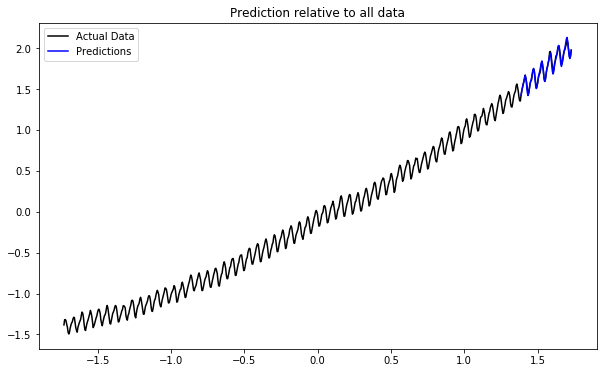

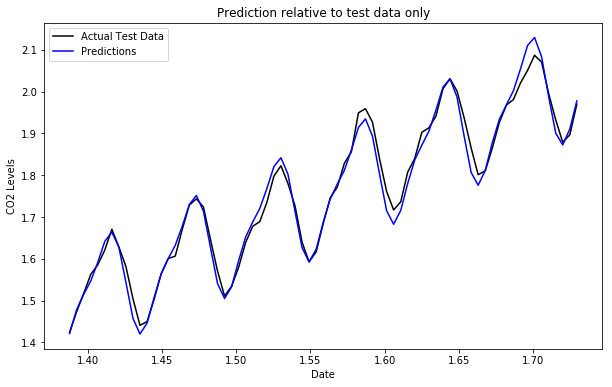

In [6]:
test_greedy_regression()